# S2DS Gophr - Model 3 implementation
Predict the likelihood of acceptance for a single event in which an individual courier is offered a job.

In [1]:
# package imports
import numpy as np
import pandas as pd
pd.options.display.max_columns = None 
pd.options.display.max_rows = None
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'darkgrid', color_codes = True)
sns.set_context("notebook", font_scale = 1.4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 12
%config InlineBackend.figure_format = "retina"
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
# from source-tree
import xgboost as xgb
import utils
import data
import features
import models
%load_ext autoreload
%autoreload 2

## 1 Import dataset and generate features

In [2]:
# load cleaned event-based dataset
df = pd.read_feather(utils.path_to('data', 'final', 'df_clean_event.feather'))

# generate features
df, feature_names  = features.generate_features(df)

Timed categorising: earliest_pickup_time
Timed categorising: delivery_deadline
Unchanged features: show_on_board, is_first_war_job, temp, feels_like, humidity, wind_speed, clouds_all, is_daytime
Engineering individual features
Log transforming: distance, initial_time_buffer, estimated_journey_time, courier_earnings_calc, size_min, size_med, size_max, weight, volume, size_min_max
Minimum of initial_time_buffer is less or equal to 0: -12839.0, adding constant of 12840.0 prior to log.
Minimum of courier_earnings_calc is less or equal to 0: -5904.46, adding constant of 5905.46 prior to log.
One hot encoding: is_food, is_fragile, is_liquid, is_not_rotatable, is_glass, is_baked, is_flower, is_alcohol, is_beef, is_pork
One hot encoding: vehicle_type, job_priority, weather_cats, earliest_pickup_time_month, earliest_pickup_time_day, earliest_pickup_time_hour, pickup_zone, delivery_zone
Cyclic encoding: earliest_pickup_time
Cyclic encoding: delivery_deadline


In [3]:
# check target variable 
print(df['event'].value_counts())
print(df['event'].dtype)

# set target variable to y
y = df['event'].cat.codes

rejected    178628
accepted    147007
Name: event, dtype: int64
category


## 2 Split data

In [4]:
# split data into a train and test dataset
X_train, X_test, y_train, y_test = models.split_data(X=df[feature_names], 
                                                     y=y,
                                                     test_size=0.25)

Train size:   244226
Test size:     81409
Minority-ratio 54.9%
Features:        110


## 3 Predictive modeling

### 3.1 Fit Logistic Regression

In [38]:
# run default Logistic Regression
clf_lr_default = LogisticRegression(max_iter=800).fit(X_train, y_train)

# evaulate the model performance
models.eval_model_performance(y_test, X_test, clf_lr_default, name='LogReg default')

/Users/felixschrank/anaconda3/envs/s2ds/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,precision,recall,fscore,sensitivity,specificity,TN,FP,FN,TP,AUC
LogReg default,0.67371,0.838256,0.747029,0.838256,0.506694,18622,18130,7223,37434,0.749692


In [19]:
# save model
models.save_model(clf_lr_default, 'clf_lg_model_4.bin')

Saved: <class 'sklearn.linear_model._logistic.LogisticRegression'>.


### 3.2 Fit XGBoost

In [15]:
# run default XGBoost
clf_xgb_default = xgb.XGBClassifier().fit(X_train, y_train)

# run XGBoost with optimzed hyperparameter
clf_xgb_tuned = models.Xgb_m4().fit(X_train, y_train)

# evaluate model performance
models.eval_model_performance(y_test, X_test, clf_xgb_default, clf_xgb_tuned,
                              name=['LogReg default','XGB default'])

,precision,recall,fscore,sensitivity,specificity,TN,FP,FN,TP,AUC
LogReg default,0.665644,0.830710,0.739072,0.830710,0.492980,18118,18634,7560,37097,0.734427
XGB default,0.736405,0.834539,0.782407,0.834539,0.637027,23412,13340,7389,37268,0.830102


In [16]:
# save a model
models.save_model(clf_xgb_tuned, 'clf_xgb_model_4.bin')

Saved: <class 'xgboost.sklearn.XGBClassifier'>.


#### XGB hyperparameter tuning

In [12]:
# find booster-limits
cv_test = models.Xgb_m4()
cv_test.fit_xgb_cv(X_train, y_train)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
184,0.887419,0.000865,0.830998,0.00107


In [9]:
# XGB with gridsearch
parameter_grid_xgb = {'max_depth': [8,10,12],
                    'learning_rate': [0.3],
                    'min_child_weight': [1,4,6],
                    'gamma': 1,
                    'subsample': [1],
                    'colsample_bytree': [1],
                    'reg_lambda':1 ,
                    'reg_alpha': [0.01],
                    'scale_pos_weight':1,
                    'n_estimators':40}

gs_xgb = models.Xgb_m4()
clf_gs = gs_xgb.gridsearch_fit(X_train, y_train, parameter_grid_xgb)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.4min
[Parallel(n_jobs=4)]: Done  33 out of  36 | elapsed:  7.3min remaining:   39.9s
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:  7.3min finished


Best parameters found:
 {'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_weight': 6, 'n_estimators': 40, 'objective': 'binary:logistic', 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 1, 'silent': False, 'subsample': 1}


## 4. Model evaluation

In [20]:
# load models
clf_xgb_tuned = models.load_model('clf_xgb_model_4.bin')
clf_lr_default = models.load_model('clf_lg_model_4.bin')

Loaded: <class 'xgboost.sklearn.XGBClassifier'>.
Loaded: <class 'sklearn.linear_model._logistic.LogisticRegression'>.


In [30]:
# evaluate model performance
models.eval_model_performance(y_test, X_test, clf_lr_default, clf_xgb_tuned,
                              name=['Logistic Regression', 'XGBoost'])

,precision,recall,fscore,sensitivity,specificity,TN,FP,FN,TP,AUC
Logistic Regression,0.665644,0.830710,0.739072,0.830710,0.492980,18118,18634,7560,37097,0.734427
XGBoost,0.743603,0.826477,0.782853,0.826477,0.653733,24026,12726,7749,36908,0.811470


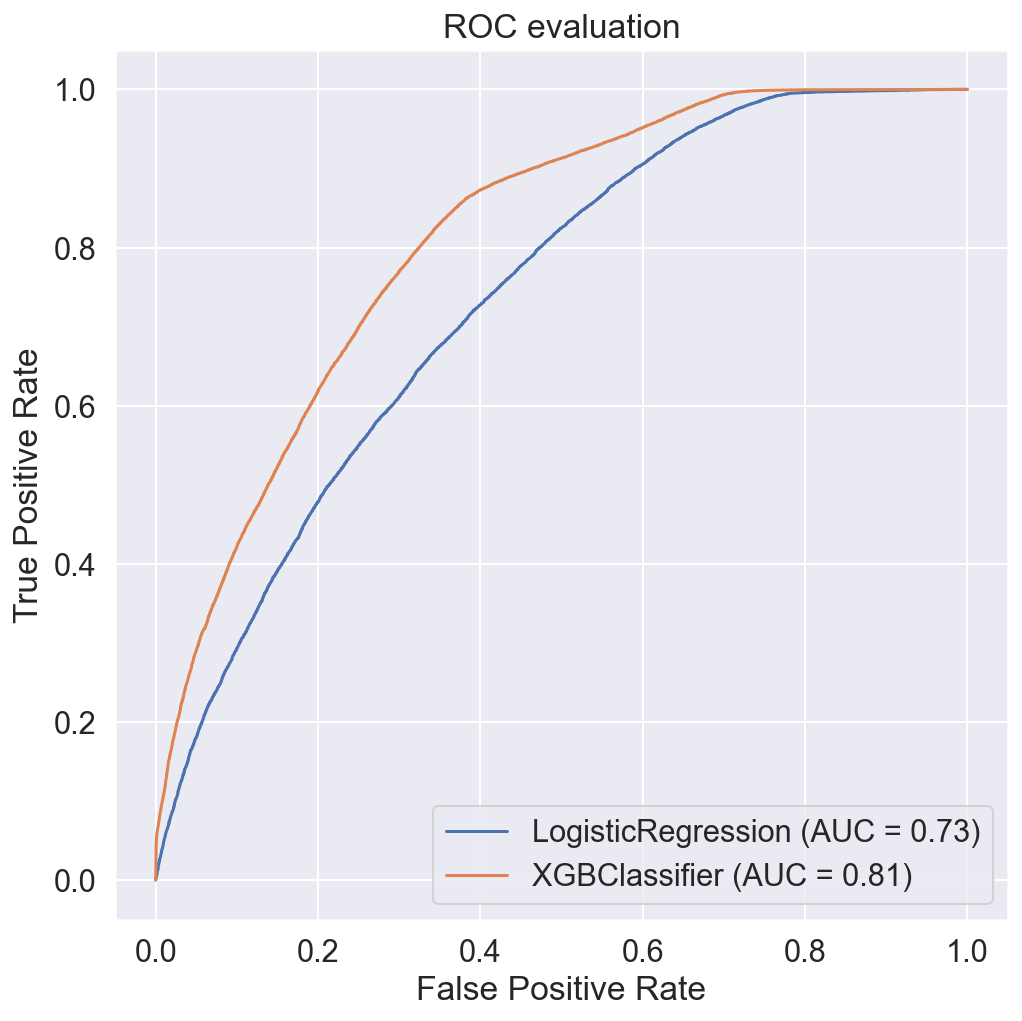

In [29]:
from sklearn.metrics import plot_roc_curve

# plot ROC curves
fig, ax = plt.subplots(figsize=(8,8))
plot_roc_curve(clf_lr_default, X_test, y_test, ax=ax)
plot_roc_curve(clf_xgb_tuned, X_test, y_test, ax=ax)
plt.title('ROC evaluation')
plt.show()

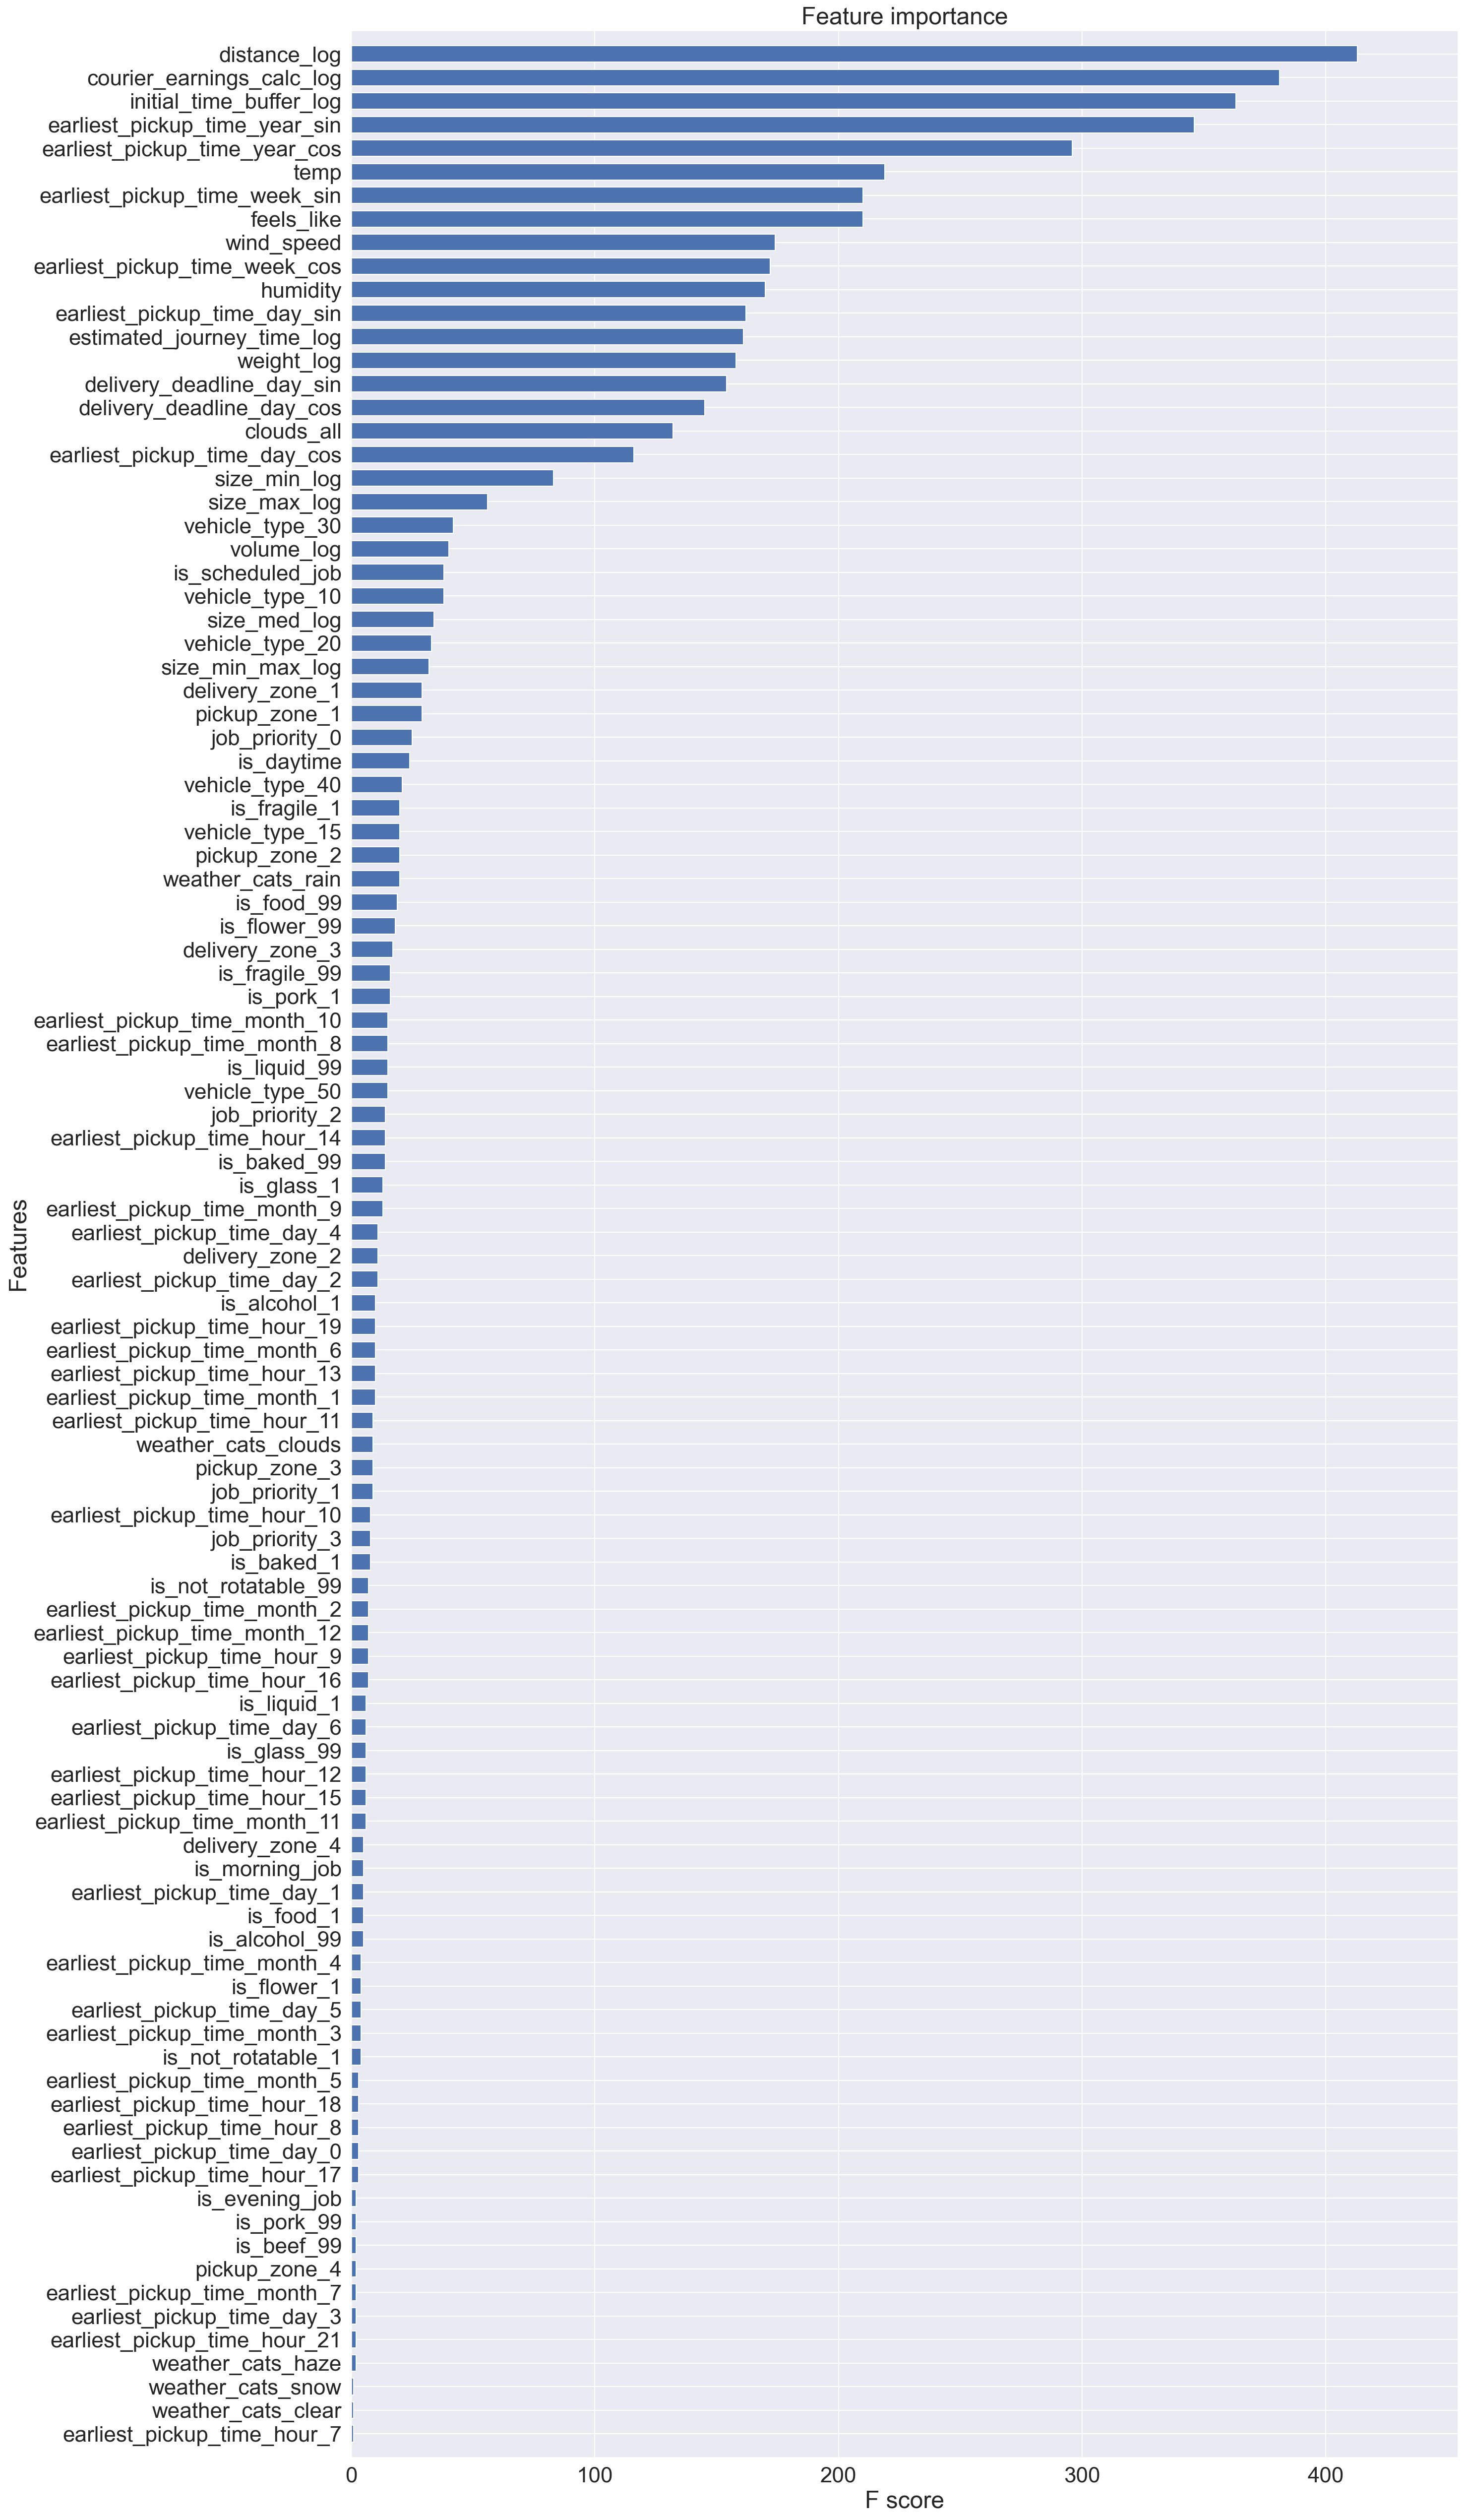

In [36]:
# Plot feature importance
sns.set(style = 'darkgrid', color_codes = True)
sns.set_context("notebook", font_scale = 2)
fig, ax = plt.subplots(figsize=(20,45))
xgb.plot_importance(clf_xgb_default, show_values=False, height=.7, ax=ax)
plt.show() 